Problem:

In this project, we aim to build a predictive model to determine whether a hotel booking would be canceled, which is crucial for hotels as cancellations affect revenue and operational planning. The dataset contains a high number of features related to booking, such as lead time, deposit type, and special requests, which adds to the complexity of the model. The challenge lies in the data preprocessing steps, which include feature selection and engineering, handling missing values, and noise in the data. Additionally, we are going to train different models, evaluate their performance using the right metrics, and interpret the model by analyzing the most important features in the context of hotel booking cancellations.



Objectives:

* __Explore the Dataset__: Investigate the dataset's basic information, summary statistics for numerical and categorical variables.
* __Preprocessing Steps__:
  - Select and engineer features 
  - Handle missing values
  - Handle noisy data
  - Encode categorical variables
* __Model Building__:
  - Implement and tune classification models including Decision Trees, Random Forest, and XGBoost.
  - Emphasize achieving high F1-score for class 1, ensuring comprehensive identification of booking cancellations
* __Evaluate and Compare Model Performance__: Utilize accuracy, precision, recall, F1-score, and AUC to gauge models' effectiveness.
* __Analyze Feature Importance__: Understand which features have the most influence on the predictions.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [2]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': 'lavender'}, style='darkgrid')

In [3]:
# Read dataset
df = pd.read_csv('/kaggle/input/hotel-bookingcvs/hotel_booking.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


Step 3.1  Dataset Basic Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# Based on the given dataset description, list the columns that are categorical in terms of their semantics
categorical_columns_semantics = [
    'hotel',
    'is_canceled',
    'arrival_date_year',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
    'name',
    'email',
    'phone-number',
    'credit_card'
]

# Convert these columns to string (object) data type
for column in categorical_columns_semantics:
    if column in df.columns:
        df[column] = df[column].astype(str)

# Verify the changes in data types
df.dtypes

hotel                              object
is_canceled                        object
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                  object
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

Step 3.2 Summary Statistics for Numerical Variables

In [6]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0


Step 3.3 Summary Statistics for Categorical Variables

In [7]:
# Get the summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
is_canceled,119390,2,0,75166
arrival_date_year,119390,3,2016,56707
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,119390,178,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
is_repeated_guest,119390,2,0,115580
reserved_room_type,119390,10,A,85994


Step 4 | Data Preprocessing

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Data preprocessing is a crucial step in any machine learning project. It involves cleaning and transforming raw data into a format that can be understood by machine learning algorithms.

<a id="engineering"></a>
# <b><span style='color:darkturquoise'>Step 4.1 |</span><span style='color:royalblue'> Feature Selection and Engineering</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

In the __Feature Selection and Engineering__ step, we prepare the dataset for modeling by performing several crucial activities:

1. **Removing Directly Related Features:** We remove features that are directly related to the target variable to prevent data leakage and ensure a fair evaluation of the model.
   
    
2. **Dropping Irrelevant Features:** Next, we drop irrelevant features that do not provide any useful information for predicting the target variable.
   
    
3. **Engineering and Dropping High-Cardinality Features:** We engineer some high-cardinality features to extract relevant information and then drop all high-cardinality features, including the ones from which we extracted information.

These activities help in reducing the dimensionality of the dataset, preventing data leakage, and creating new features that may provide additional information for the model.


In [8]:
# Reload the dataset to retain the original data types of the variables
df = pd.read_csv('/kaggle/input/hotel-bookingcvs/hotel_booking.csv')

<a id="direct"></a>
## <b><span style='color:darkturquoise'>Step 4.1.1 |</span><span style='color:royalblue'> Remove Directly Related Features</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Features like `reservation_status`, `reservation_status_date` and `assigned_room_type` are directly related to the target variable `is_canceled`, and including them in the model would result in __data leakage__. Removing these features is essential to build a predictive model that can genuinely forecast cancellations, rather than retrospectively label them:

<a id="basic"></a>
## <b><span style='color:darkturquoise'>Step 4.1.1.1 |</span><span style='color:royalblue'> reservation_status</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

`reservation_status` is a categorical feature that indicates the current status of a reservation. It can have values like '__Canceled__', '__Check-Out__', and '__No-Show__'. This feature is directly related to the target variable `is_canceled` for the following reasons:

- If the `reservation_status` is '__Canceled__', it implies that `is_canceled` should be 1.

    
- Similarly, if the `reservation_status` is '__Check-Out__', it implies that the booking was not canceled, and hence `is_canceled` should be 0.

Therefore, knowing the `reservation_status` directly gives us the value of the target variable, leading to data leakage if it is used as a feature in the model. So, it is important to remove this feature to build a model that can actually predict cancellations. Therefore, `reservation_status` is considered as an irrelevant feature and should be omitted.


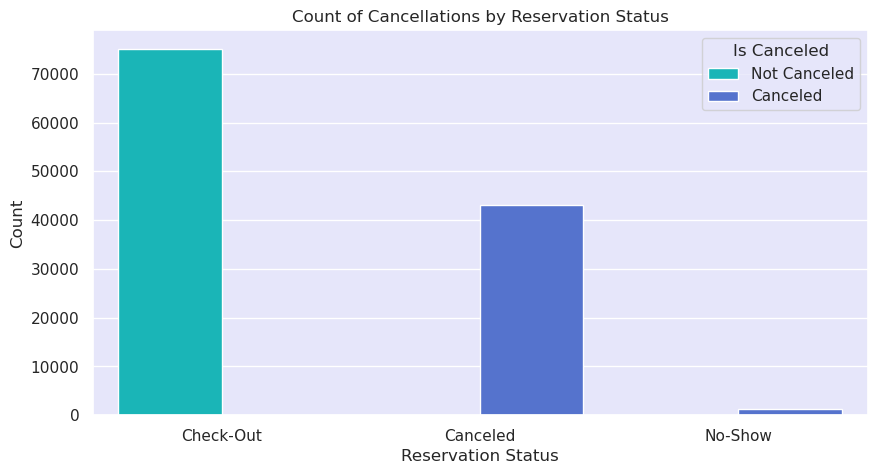

In [9]:
# Bivariate bar plot of 'is_canceled' vs 'reservation_status' with specified colors
plt.figure(figsize=(10, 5))
sns.countplot(x='reservation_status', hue='is_canceled', data=df, palette=['darkturquoise', 'royalblue'])
plt.title('Count of Cancellations by Reservation Status')
plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'])
plt.show()

In [10]:
df.groupby('reservation_status')['is_canceled'].mean()

reservation_status
Canceled     1.0
Check-Out    0.0
No-Show      1.0
Name: is_canceled, dtype: float64

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
<h3 align="left"><font color=royalblue>Inference:</font></h3>
    
It is clear from the plot that all the bookings with a reservation_status of "__Canceled__" or "__No-Show__" are indeed canceled (__`is_canceled`= 1__), and all the bookings with a reservation_status of "__Check-Out__" are not canceled (__`is_canceled` = 0__).

This confirms that the `reservation_status` feature is directly related to the `is_canceled` target variable and including it in the model would cause __data leakage__. Therefore, it is essential to remove the reservation_status feature before training the model.

In [11]:
# Drop the `reservation_status` feature
df = df.drop(['reservation_status'], axis=1)

<a id="basic"></a>
## <b><span style='color:darkturquoise'>Step 4.1.1.2 |</span><span style='color:royalblue'> reservation_status_date</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

`reservation_status_date` is a date feature that indicates the latest date at which the `reservation_status` was updated. This feature is directly related to the target variable `is_canceled` for the following reasons:

- If a booking was canceled, the `reservation_status_date` would be the date on which the booking was canceled, implying that `is_canceled` should be 1.

    
- On the other hand, if a booking was not canceled, the `reservation_status_date` would reflect the date of check-out, implying that `is_canceled` should be 0.

Therefore, the `reservation_status_date` can indirectly give us information about the value of the target variable, leading to data leakage if it is used as a feature in the model. 

Let's investigate it precisely:

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

The `reservation_status_date` column is a date variable that represents the date of the last reservation status. Since it is a date, it will likely be in a '__YYYY-MM-DD__' format. We can extract some useful information from it:
    
* __Days_Difference__: Calculate the difference in days between the `reservation_status_date` and the `arrival_date` to create a new feature representing the number of days between the last reservation status and the arrival date.

In [12]:
# Convert 'reservation_status_date' to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Extract Days_Difference from 'reservation_status_date'
df['reservation_status_days_difference'] = (df['reservation_status_date'] - pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str))).dt.days

df[['reservation_status_days_difference']].head()

,reservation_status_days_difference
0,0
1,0
2,1
3,1
4,2


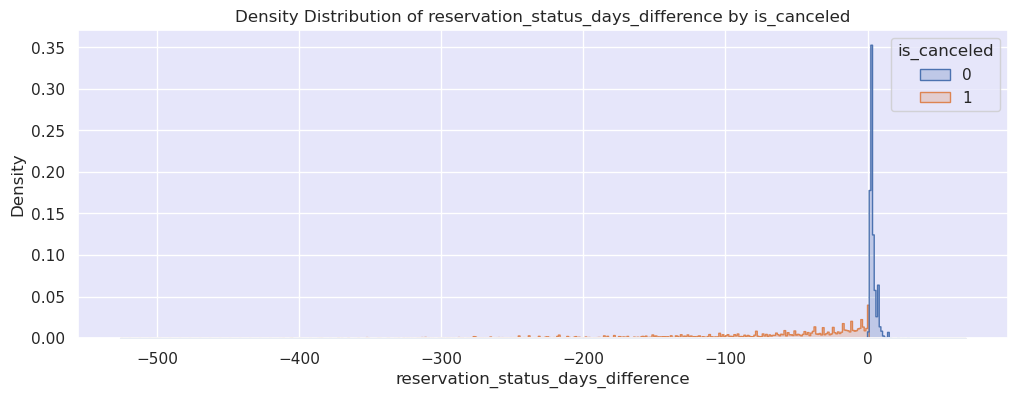

In [13]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x="reservation_status_days_difference", hue="is_canceled", element="step", stat="density", common_norm=False)
plt.title('Density Distribution of reservation_status_days_difference by is_canceled')
plt.show()

In [14]:
# For positive values of reservation_status_days_difference
print("Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:\n")
print(df[df['reservation_status_days_difference'] > 0]['is_canceled'].value_counts())

# For negative values of reservation_status_days_difference
print("\n" + "-"*85)
print("\nDistribution of 'is_canceled' when 'reservation_status_days_difference' is negative:\n")
print(df[df['reservation_status_days_difference'] < 0]['is_canceled'].value_counts())

Distribution of 'is_canceled' when 'reservation_status_days_difference' is positive:

0    74460
Name: is_canceled, dtype: int64

-------------------------------------------------------------------------------------

Distribution of 'is_canceled' when 'reservation_status_days_difference' is negative:

1    42137
Name: is_canceled, dtype: int64


<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
<h3 align="left"><font color=royalblue>Inference:</font></h3>
    
The `reservation_status_days_difference` feature represents the number of days between the arrival date and the date at which the reservation status was last updated.

- __Positive values__ indicate that the reservation status was updated after the arrival date. Since `is_canceled` is always 0 for these rows, it suggests that these bookings were not canceled and the reservation status was updated (e.g., to '__Check-Out__') after the guest arrived.

    
- __Negative values__ indicate that the reservation status was updated before the arrival date. Since `is_canceled` is always 1 for these rows, it suggests that these bookings were canceled before the arrival date.

This shows a clear relationship between the `reservation_status_days_difference` and the `is_canceled` feature. If a booking is canceled, the reservation status is usually updated before the arrival date. Conversely, if a booking is not canceled, the reservation status is usually updated after the arrival date. 

____
    
Therefore, it is advisable to omit both the `reservation_status_date` and the `reservation_status_days_difference` features from the model. The latter was derived from the former, and both lead to data leakage, which could result in a model that does not generalize well to new data:

In [15]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status_days_difference'], axis=1)

<a id="basic"></a>
## <b><span style='color:darkturquoise'>Step 4.1.1.3 |</span><span style='color:royalblue'> assigned_room_type</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

The `assigned_room_type` feature represents the type of room assigned to the guest. It is assigned after the booking is made, so it cannot be used to predict cancellations. Therefore, `assigned_room_type` is considered as an irrelevant feature and should be omitted:

In [16]:
df = df.drop(['assigned_room_type'], axis=1)

<a id="irrelevant"></a>
## <b><span style='color:darkturquoise'>Step 4.1.2 |</span><span style='color:royalblue'> Drop Irrelevant Features</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

The `arrival_date_year` feature only includes a few years, and if we want to build a model that generalizes well to future data, it is advisable not to include features that could bias the model towards specific years. Therefore, it is reasonable to consider `arrival_date_year` as an irrelevant feature and it should be omitted.

In [17]:
df['arrival_date_year'].value_counts()


2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64

In [18]:
# Drop the `arrival_date_year` feature
df = df.drop(['arrival_date_year'], axis=1)

<a id="cardinality"></a>
## <b><span style='color:darkturquoise'>Step 4.1.3 |</span><span style='color:royalblue'> Engineer and Drop High-Cardinality Features</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Based on our findings regarding the features of the dataset from the previous steps, there are a number of categorical features which, due to the large number of categories (high cardinality), probably do not have specific information for the model and should be considered as irrelevant features and should be deleted. However, before that, we will check whether it is possible to extract useful information from the features before droping them:

In [19]:
# Create a dataframe with the number of unique categories and missing values for each high-cardinality feature
high_cardinality_features = ['country', 'agent', 'company', 'name', 'email', 'phone-number', 'credit_card']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,177,488
agent,333,16340
company,352,112593
name,81503,0
email,115889,0
phone-number,119390,0
credit_card,9000,0


<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

- __`country`__:
    - __Description__: Country of origin of the guest.
    - __Action__: We will remove this feature for ease of work due to the large number of categories. However, one way to handle this, if needed in future work, is to group the countries into regions (e.g., North America, Europe, Asia, etc.) or to keep only the top N most frequent countries and group the rest into an 'Other' category.

    
- __`agent`__:
    - __Description__: ID of the travel agent responsible for the booking.
    - __Action__: This feature has several unique categories, and some agents may only appear a few times in the dataset, which could cause overfitting. We could create a new feature representing the number of bookings made by each agent and then drop the original `agent` feature. However, this new feature may not be very meaningful because the number of bookings made by an agent may not be directly related to the cancellation rate. We will omit this feature.

    
- __`company`__:
    - __Description__: ID of the company responsible for the booking.
    - __Action__: This feature has a high percentage of missing values and may not be very informative for predicting cancellations, so it may be better to drop it entirely.

    
- __`name`__:
    - __Description__: Guest's name.
    - __Action__: This feature has many unique categories and is not directly related to the cancellation rate. However, we could create a new feature representing the number of bookings made by each guest (based on the name) and then drop the original `name` feature. This new feature could be useful because repeat guests may have different cancellation behaviors than first-time guests.

    
- __`email`__:
    - __Description__: Guest's email address.
    - __Action__: Similar to the `name` feature, we could create a new feature representing the number of bookings made by each guest (based on the email) and then drop the original `email` feature. This new feature could capture the same information as the `name` feature, so it may be redundant to keep both. We will omit this feature.

    
- __`phone-number`__:
    - __Description__: Guest's phone number.
    - __Action__: This feature is like an identifier because all the rows have different `phone-number` values, so this feature has no information and we will omit this feature.

    
- __`credit_card`__:
    - __Description__: Last four digits of the guest's credit card.
    - __Action__: This feature may have many unique categories and is not directly related to the cancellation rate. It may be better to drop this feature entirely.

In summary, the `country`, `agent`, `company`, `email`, `phone-number`, and `credit_card` features will be omitted from the model due to their high cardinality, high percentage of missing values, or lack of direct relationship with the cancellation rate (`is_canceled`). The `name` feature will be engineered to create a new feature representing the number of bookings made by each guest, and then the original `name` feature will be dropped.


In [20]:
# Feature Engineering for 'name' feature
# Create a new feature representing the number of bookings made by each guest (based on the name)
df['number_of_bookings'] = df.groupby('name')['name'].transform('count')

# Drop the original 'name' feature and other high-cardinality features
df = df.drop(['name', 'country', 'agent', 'company', 'email', 'phone-number', 'credit_card'], axis=1)

df[['number_of_bookings']].head()

,number_of_bookings
0,1
1,2
2,3
3,1
4,1


<a id="missing"></a>
# <b><span style='color:darkturquoise'>Step 4.2 |</span><span style='color:royalblue'> Handle Missing Values</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

I am going to analyze the missing values in each column. If a column has a high percentage of missing values, it may be better to drop the column entirely. For columns with a small percentage of missing values, we can impute the missing values with the mean, median, or mode of the column, or use more advanced imputation techniques like K-nearest neighbors imputation:

In [21]:
# Calculate the missing values percentage in the original dataset
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage[missing_values_percentage > 0]

children    0.00335
dtype: float64

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
<h2 align="left"><font color=royalblue>Inference:</font></h2>
    
The `children` feature has a very low percentage of missing values (0.003350%) and is a numerical feature. Given the distribution of values in the children column, the majority of bookings have 0 children, which is a strong mode. Therefore, it would be reasonable to impute the missing values with 0 (the mode of the column). This approach is simple and will not introduce significant bias:

In [22]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [23]:
# Impute missing values in 'children' column with 0
df['children'] = df['children'].fillna(0)

# Check if there are any missing values left in 'children' column
df['children'].isnull().sum()

0

<a id="noise"></a>
# <b><span style='color:darkturquoise'>Step 4.3 |</span><span style='color:royalblue'> Handle Noisy Data</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Now let's analyze and handle the __noisy data__ in the `adr`, `adults`, `children`, and `babies` columns as discussed in __step 3.2__:

In [24]:
# Analyze noisy data
noisy_data = {
    'adr':      df[df['adr'] < 0],
    'adults':   df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies':   df[df['babies'] == 10],
}

noisy_data_count = {key: len(value) for key, value in noisy_data.items()}
noisy_data_count

{'adr': 1, 'adults': 403, 'children': 1, 'babies': 1}

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
<h2 align="left"><font color=royalblue>Inference:</font></h2>

We have identified some noisy data in the following features:

- `adr`: There is __1__ booking with a negative Average Daily Rate (ADR), which doesn't make sense and indicates a potential error or special case.

    
- `adults`: There are __403__ bookings with 0 adults, which could be a data entry error unless there are legitimate cases where only children or babies book a room.

    
- `children`: There is __1__ booking with 10 children, which seems unusually high for a single booking and could be a potential outlier or data entry error.

    
- `babies`: There is __1__ booking with 10 babies, which seems unusually high for a single booking and could be a potential outlier or data entry error.

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
<h3 align="left"><font color=royalblue>Approach to Address Noisy Data:</font></h3>

For each of these features, the best treatment would be:

- `adr`: Since there is only one negative value, it would be reasonable to replace it with the median or mean of the `adr` column, as this will not significantly affect the distribution of the data.

    
- `adults`: It is unlikely that a booking would be made with 0 adults, so these 403 rows seem to be errors. Given that this is a small proportion of the dataset, it would be reasonable to remove these rows.

    
- `children`: Since there is only one booking with 10 children, it could be considered as an outlier and removed from the dataset.

    
- `babies`: Similar to the `children` column, since there is only one booking with 10 babies, it could be considered as an outlier and removed from the dataset.

In [25]:
# Replace negative adr with median of adr column
df.loc[df['adr'] < 0, 'adr'] = df['adr'].median()

# Remove rows with 0 adults
df = df[df['adults'] != 0]

# Remove rows with 10 children or 10 babies
df = df[df['children'] != 10]
df = df[df['babies'] != 10]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check if the noisy data has been handled
noisy_data_handled = {
    'adr': df[df['adr'] < 0],
    'adults': df[df['adults'] == 0],
    'children': df[df['children'] == 10],
    'babies': df[df['babies'] == 10],
}

noisy_data_handled_count = {key: len(value) for key, value in noisy_data_handled.items()}
noisy_data_handled_count

{'adr': 0, 'adults': 0, 'children': 0, 'babies': 0}

<a id="encode"></a>
# <b><span style='color:darkturquoise'>Step 4.4 |</span><span style='color:royalblue'> Encode Categorical Variables</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
    
After analyzing the dataset, we can categorize the features into three groups:

1. __No Encoding Needed__: These are the features that do not require any form of encoding because they are already in a numerical format that can be fed into a model.

    
2. __One-Hot Encoding__: This is required for nominal variables, which are categorical variables without any intrinsic order. One-hot encoding converts each unique value of the feature into a separate column with a 1 or 0, indicating the presence of that value. 

    
3. __Label Encoding__: This is used for ordinal variables, which are categorical variables with a meaningful order. Label encoding assigns a unique integer to each category in the feature, maintaining the order of the values.

By categorizing the features into these groups, we can apply the appropriate encoding method to each feature, preparing the dataset for modeling.


In [26]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>No Encoding Needed:</font></h3>

The following features do not require any encoding as they are either numerical, binary, or ordinal variables that have already been encoded as numbers:

- `is_canceled`: This is the target variable and is binary.
- `lead_time`: This is a numerical variable.
- `arrival_date_week_number`: This is a numerical variable.
- `arrival_date_day_of_month`: This is a numerical variable.
- `stays_in_weekend_nights`: This is a numerical variable.
- `stays_in_week_nights`: This is a numerical variable.
- `adults`: This is a numerical variable.
- `children`: This is a numerical variable.
- `babies`: This is a numerical variable.
- `is_repeated_guest`: This is a binary variable.
- `previous_cancellations`: This is a numerical variable.
- `previous_bookings_not_canceled`: This is a numerical variable.
- `booking_changes`: This is a numerical variable.
- `days_in_waiting_list`: This is a numerical variable.
- `adr`: This is a numerical variable.
- `required_car_parking_spaces`: This is a numerical variable.
- `total_of_special_requests`: This is a numerical variable.
- `number_of_bookings`: This is a numerical variable.

<h3 align="left"><font color=royalblue>One-Hot Encoding:</font></h3>

The following features are nominal variables and should be one-hot encoded:

- `hotel`: This is a nominal variable with two categories.
- `meal`: This is a nominal variable.
- `market_segment`: This is a nominal variable.
- `distribution_channel`: This is a nominal variable.
- `reserved_room_type`: This is a nominal variable.
- `deposit_type`: This is a nominal variable.
- `customer_type`: This is a nominal variable.

<h3 align="left"><font color=royalblue>Label Encoding:</font></h3>    

The following feature is an ordinal variable and should be label encoded:

- `arrival_date_month`: This is an ordinal variable (months have a natural order).


In [27]:
# Convert 'arrival_date_month' to numerical values
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)

# One-hot encode the specified columns
one_hot_cols = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

<a id="imbalance"></a>
# <b><span style='color:darkturquoise'>Step 4.5 |</span><span style='color:royalblue'> Check Imbalanced Data</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

If the target variable `is_canceled` is imbalanced, we may need to balance the dataset. Let's check:

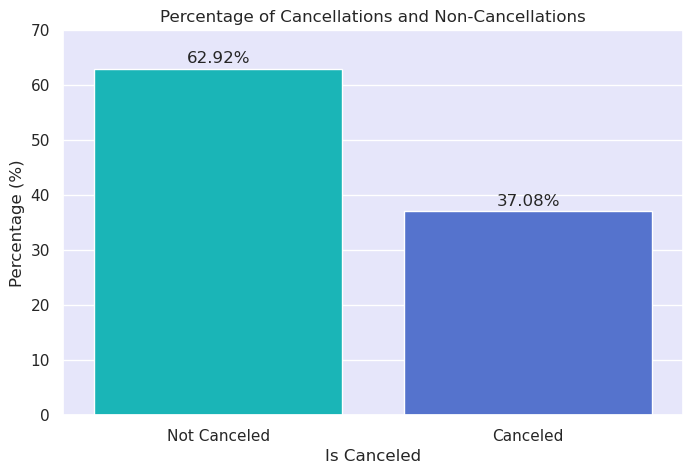

In [28]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>Inference:</font></h3>
    
The bar plot shows the percentage of cancellations and non-cancellations in the dataset. Approximately 37.08% of the bookings were canceled, and 62.92% were not canceled. This indicates that there is some imbalance in the target variable, but it is not highly imbalanced. Generally, a dataset is considered highly imbalanced if one class represents over 80-90% of the data. In this case, the minority class (canceled) is still well-represented, so it may not be necessary to apply any resampling techniques (e.g., oversampling, undersampling) to balance the classes. However, it is always good to try different approaches and evaluate the model's performance to decide the best approach.

<a id="split"></a>
# <b><span style='color:darkturquoise'>Step 4.6 |</span><span style='color:royalblue'> Split the Dataset</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
    
Finally, lets split the dataset into training and testing sets:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118985 entries, 0 to 118984
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118985 non-null  int64  
 1   lead_time                       118985 non-null  int64  
 2   arrival_date_month              118985 non-null  int64  
 3   arrival_date_week_number        118985 non-null  int64  
 4   arrival_date_day_of_month       118985 non-null  int64  
 5   stays_in_weekend_nights         118985 non-null  int64  
 6   stays_in_week_nights            118985 non-null  int64  
 7   adults                          118985 non-null  int64  
 8   children                        118985 non-null  float64
 9   babies                          118985 non-null  int64  
 10  is_repeated_guest               118985 non-null  int64  
 11  previous_cancellations          118985 non-null  int64  
 12  previous_booking

In [30]:
# Define the features (X) and the output labels (y)
X = df.drop('is_canceled', axis=1)
y = df['is_canceled'] 

In [31]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>Note:</font></h3>
    
* In the above split, we used __Stratification__ which ensures that the distribution of the target variable (`is_canceled`) is the same in both the train and test sets

<a id="dt"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 5 | Decision Tree Model Building</p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="dt_base"></a>
# <b><span style='color:darkturquoise'>Step 5.1 |</span><span style='color:royalblue'>  DT Base Model Definition</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

First of all, let's define the base DT model:

In [32]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

<a id="dt_hp"></a>
# <b><span style='color:darkturquoise'>Step 5.2 |</span><span style='color:royalblue'>  DT Hyperparameter Tuning</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>🎯 Note:</font></h3>

In this hotel booking problem, the target variable is `is_canceled`, which indicates whether a booking was canceled (1) or not (0). Both false positives (a booking is predicted as canceled, but it is not) and false negatives (a booking is predicted as not canceled, but it is) could be costly for the hotel. 

However, false negatives may be more costly because the hotel might lose potential customers by overbooking rooms, expecting some cancellations that do not happen. Therefore, it is important to minimize false negatives, which means maximizing recall for the 'canceled' class (1) would be a good approach.

Precision is also important because it minimizes false positives, which means minimizing the cases where the model predicts a cancellation, but the guest actually arrives. This could lead to overbooking and unsatisfied customers.

Therefore, the F1-score, which is the harmonic mean of precision and recall, would be a good metric to use as it balances both precision and recall. Specifically, __the F1-score for the 'canceled' class (1) would be the most important metric for evaluating models in this project.__

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

I will create a function to identify the best set of hyperparameters that maximize the __F1-score for class 1 (canceled bookings)__. This method provides a reusable framework for hyperparameter tuning for other models as well:

In [33]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

I will establish the grid of hyperparameters and use the __tune_clf_hyperparameters__ function to determine the most suitable hyperparameters for our Decision Tree (DT) model:


In [34]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue> Note:</font></h3>

Since the data is slightly imbalanced and we want to optimize for class 1, we have included the `class_weight` parameter in our grid. In the grid above, the weight for class 0 is always 1, while the weight for class 1 varies from 1 to 5. This will help the model to focus more on class 1.

In [35]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [36]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


<a id="dt_evaluation"></a>
# <b><span style='color:darkturquoise'>Step 5.3 |</span><span style='color:royalblue'>  DT Model Evaluation</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

To streamline the evaluation of different models, we will define a set of functions that compute key performance metrics. This approach will ensure consistency in how we assess each model and facilitate comparisons between them:

In [37]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [38]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
    
Let's call the above function for evaluating our DT classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     59897
           1       0.74      0.85      0.79     35291

    accuracy                           0.83     95188
   macro avg       0.82      0.84      0.83     95188
weighted avg       0.84      0.83      0.84     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     14974
           1       0.70      0.81      0.75      8823

    accuracy                           0.80     23797
   macro avg       0.79      0.80      0.79     23797
weighted avg       0.81      0.80      0.81     23797



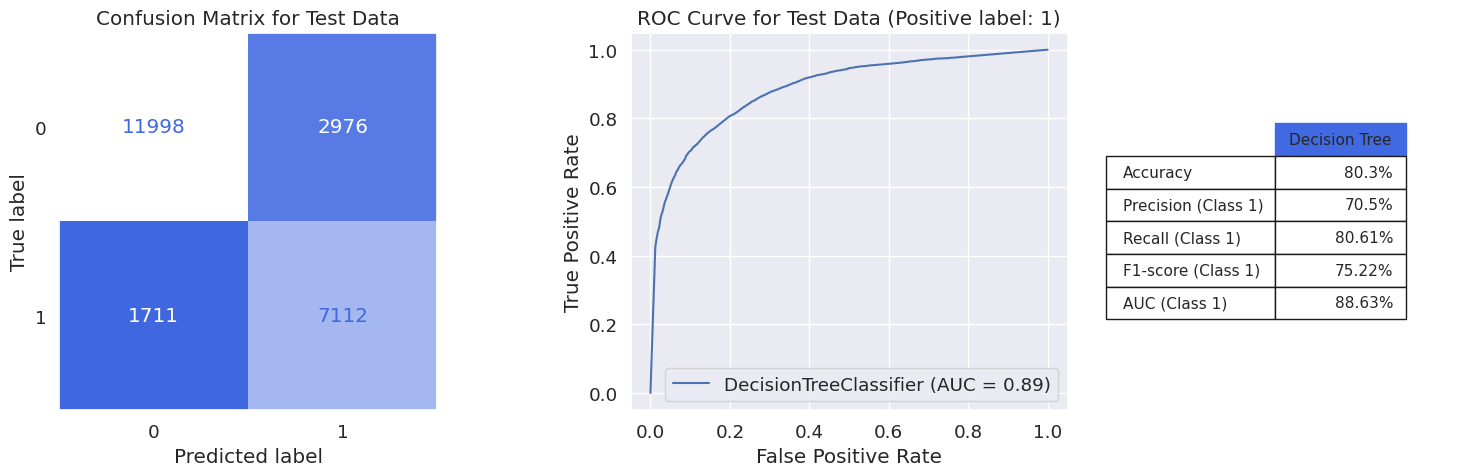

In [39]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>✅ Inference:</font></h3>

Our __DT model's performance__ on the test data is as follows:

- The **Accuracy** is 80.3%, which means the model is correctly predicting whether a booking will be canceled or not about 80% of the time.

- The **Precision** for class 1 (cancellations) is 70.5%, which means that 71% of the bookings that the model predicted as canceled were actually canceled.

- The **Recall** for class 1 is 80.61%, which means that the model correctly identified 81% of the actual cancellations.

- The **F1-score** for class 1 is 75.22%, which is the harmonic mean of Precision and Recall.

- The **AUC** (Area Under the ROC Curve) for class 1 is 88.63%, which means that the model has a good discriminative power between the two classes.

The confusion matrix shows that there are still some False Positives and False Negatives, but the model is doing a relatively good job of minimizing them.

Additionally, the model is not overfitting, as the metric values for the test and train sets are close together, indicating that the model is generalizing well to unseen data.

Overall, this model is performing well on the test data and seems to be a good model for predicting cancellations, although there is room for improvement.

In [40]:
# Save the final performance of DT classifier
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,80.3%
Precision (Class 1),70.5%
Recall (Class 1),80.61%
F1-score (Class 1),75.22%
AUC (Class 1),88.63%


<a id="rf"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 6 | Random Forest Model Building</p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="rf_base"></a>
# <b><span style='color:darkturquoise'>Step 6.1 |</span><span style='color:royalblue'>  RF Base Model Definition</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

First of all, let's define the base RF model:

In [41]:
# Define the base RF model
rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

<a id="rf_hp"></a>
# <b><span style='color:darkturquoise'>Step 6.2 |</span><span style='color:royalblue'>  RF Hyperparameter Tuning</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Afterward, I'll set up the hyperparameters grid and utilize the `tune_clf_hyperparameters` function to pinpoint the optimal hyperparameters for our RF model:

In [42]:
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [{0: 1, 1: w} for w in [1, 2, 3]]
}

In [43]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [44]:
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}


<a id="rf_evaluation"></a>
# <b><span style='color:darkturquoise'>Step 6.3 |</span><span style='color:royalblue'> RF Model Evaluation</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">
    
Let's assess the performance of our trained Random Forest model using the `model_evaluation` function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     59897
           1       0.80      0.85      0.83     35291

    accuracy                           0.87     95188
   macro avg       0.86      0.86      0.86     95188
weighted avg       0.87      0.87      0.87     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     14974
           1       0.77      0.79      0.78      8823

    accuracy                           0.84     23797
   macro avg       0.83      0.83      0.83     23797
weighted avg       0.84      0.84      0.84     23797



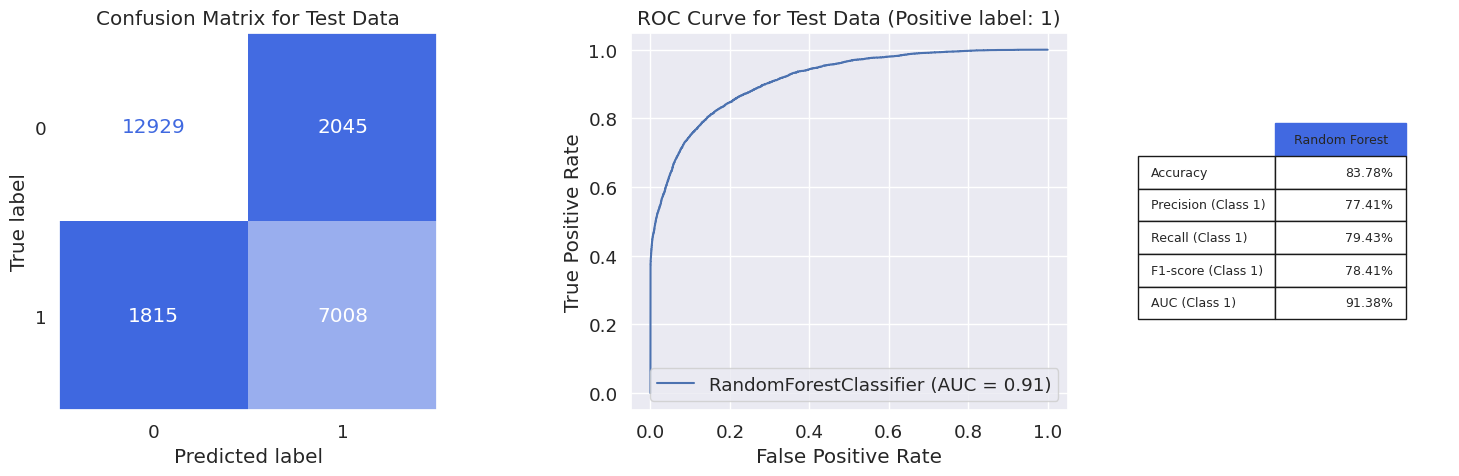

In [45]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>✅ Inference:</font></h3>

The performance of our Random Forest (RF) model on the test data is as follows:

- The **Accuracy** is 83.78%, which means the model is correctly predicting whether a booking will be canceled or not about 84% of the time.

- The **Precision** for class 1 (cancellations) is 77.41%, which means that approximately 78% of the bookings that the model predicted as canceled were actually canceled.

- The **Recall** for class 1 is 79.43%, which means that the model correctly identified approximately 80% of the actual cancellations.

- The **F1-score** for class 1 is 78.41%, which is the harmonic mean of Precision and Recall.

- The **AUC** (Area Under the ROC Curve) for class 1 is 91.38%, which means that the model has a very good discriminative power between the two classes.

The confusion matrix shows that there are some False Positives and False Negatives, but the model is doing a good job of minimizing them.

Additionally, the model is not overfitting, as the metric values for the test and train sets are close together, indicating that the model is generalizing well to unseen data.

Compared to the Decision Tree (DT) model, the Random Forest (RF) model shows a significant improvement in all the performance metrics, particularly in reducing the number of False Positives. This indicates that the Random Forest model is better at balancing the trade-off between Precision and Recall, leading to a higher F1-score.

Overall, this model is performing well on the test data and seems to be a good model for predicting cancellations, although there is still room for improvement, particularly in reducing the number of False Negatives.


In [46]:
# Save the final performance of RF classifier
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

,Random Forest
Accuracy,83.78%
Precision (Class 1),77.41%
Recall (Class 1),79.43%
F1-score (Class 1),78.41%
AUC (Class 1),91.38%


<a id="xgb"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 7 | XGBoost Model Building</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

__XGBoost__, which stands for __eXtreme Gradient Boosting__, is an efficient and scalable implementation of gradient boosting. It is a __decision-tree-based__ ensemble Machine Learning algorithm that uses a gradient boosting framework. It is particularly popular and effective for classification and regression tasks and has gained reputation for its performance and speed compared to other implementations of gradient boosting. XGBoost is designed to be efficient, flexible and portable.

<a id="xgb_base"></a>
# <b><span style='color:darkturquoise'>Step 7.1 |</span><span style='color:royalblue'>  XGBoost Base Model Definition</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

First of all, let's define the base XGBoost model. We set `use_label_encoder=False` to avoid a deprecation warning. The `eval_metric` is set to '__logloss__' because it is a more appropriate metric for binary classification tasks and for the slight class imbalance we have in our target variable:

In [47]:
# Define the model
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

<a id="xgb_hp"></a>
# <b><span style='color:darkturquoise'>Step 7.2 |</span><span style='color:royalblue'>  XGBoost Hyperparameter Tuning</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

XGBoost has several hyperparameters that need to be tuned to improve the performance of the model. Some of the important hyperparameters are:

- __`n_estimators`__: This is the number of boosting rounds or trees to be built. It is usually set to a high number, but XGBoost has an early stopping feature that stops the model building process when no further improvements are observed.

    
- __`learning_rate`__: This is the step size shrinkage used to prevent overfitting. It ranges from 0 to 1.

    
- __`max_depth`__: This is the maximum depth of a tree and can range from 1 to infinity.

    
- __`subsample`__: This is the fraction of observations to be randomly sampled for each tree. It ranges from 0 to 1.

    
- __`colsample_bytree`__: This is the fraction of features to be randomly sampled for each tree. It ranges from 0 to 1.

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

We will tune these hyperparameters using the `tune_clf_hyperparameters` function, which performs a grid search over the specified parameter grid and returns the best model.

Additionally, XGBoost has a built-in function `xgb.cv` that can be used to find the optimum __number of boosting rounds__ or `n_estimators`. This function trains the model several times on different subsets of the data and returns the optimum number of boosting rounds for which the error is minimum. However, since we are tuning `n_estimators` in the grid search, there is no need to use this function in this case.

In [48]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [49]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [50]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'scale_pos_weight': 1.697231588790343, 'subsample': 0.7}


<a id="xgb_evaluation"></a>
# <b><span style='color:darkturquoise'>Step 7.3 |</span><span style='color:royalblue'> XGBoost Model Evaluation</span></b>

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Next, let's assess the performance of our optimized XGBoost model by utilizing the `model_evaluation` function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     59897
           1       0.86      0.88      0.87     35291

    accuracy                           0.90     95188
   macro avg       0.89      0.90      0.90     95188
weighted avg       0.90      0.90      0.90     95188


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14974
           1       0.79      0.80      0.80      8823

    accuracy                           0.85     23797
   macro avg       0.84      0.84      0.84     23797
weighted avg       0.85      0.85      0.85     23797



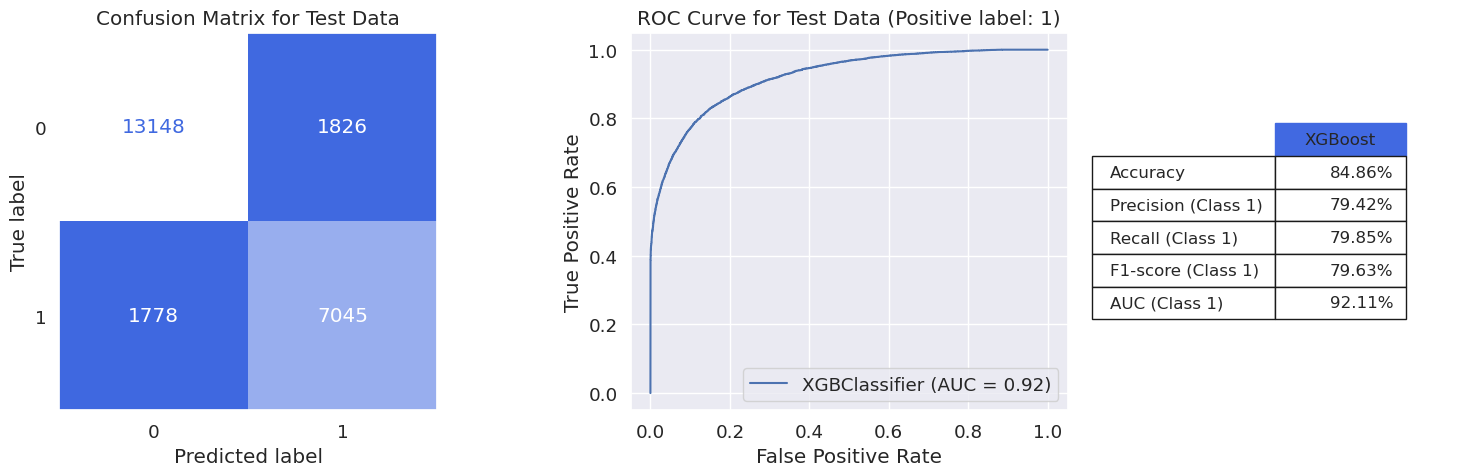

In [51]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>✅ Inference:</font></h3>

The performance of our XGBoost (XGB) model on the test data is as follows:

- The **Accuracy** is 84.9%, which means the model is correctly predicting whether a booking will be canceled or not about 85% of the time.

- The **Precision** for class 1 (cancellations) is 79.4%, which means that approximately 80% of the bookings that the model predicted as canceled were actually canceled.

- The **Recall** for class 1 is 79.8%, which means that the model correctly identified approximately 80% of the actual cancellations.

- The **F1-score** for class 1 is 79.6%, which is the harmonic mean of Precision and Recall.

- The **AUC** (Area Under the ROC Curve) for class 1 is 92.1%, which means that the model has a very good discriminative power between the two classes.

The model is not overfitting, as the metric values for the test and train sets are close together, indicating that the model is generalizing well to unseen data.

Compared to the Random Forest (RF) model, the XGBoost (XGB) model shows a slight improvement in all the performance metrics. Although the improvement is not significant, it is still better at balancing the trade-off between Precision and Recall, leading to a higher F1-score. This indicates that the XGBoost model is a better model for predicting cancellations.

Overall, this model is performing well on the test data and seems to be a good model for predicting cancellations.

In [52]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,84.86%
Precision (Class 1),79.42%
Recall (Class 1),79.85%
F1-score (Class 1),79.63%
AUC (Class 1),92.11%


<a id="xgb_imp"></a>
# <b><span style='color:darkturquoise'>Step 7.4 |</span><span style='color:royalblue'>  XGBoost Feature Importance </span></b>


<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

XGBoost, being a tree-based model, has the inherent ability to compute feature importances. Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable. It can aid in feature selection and model optimization:

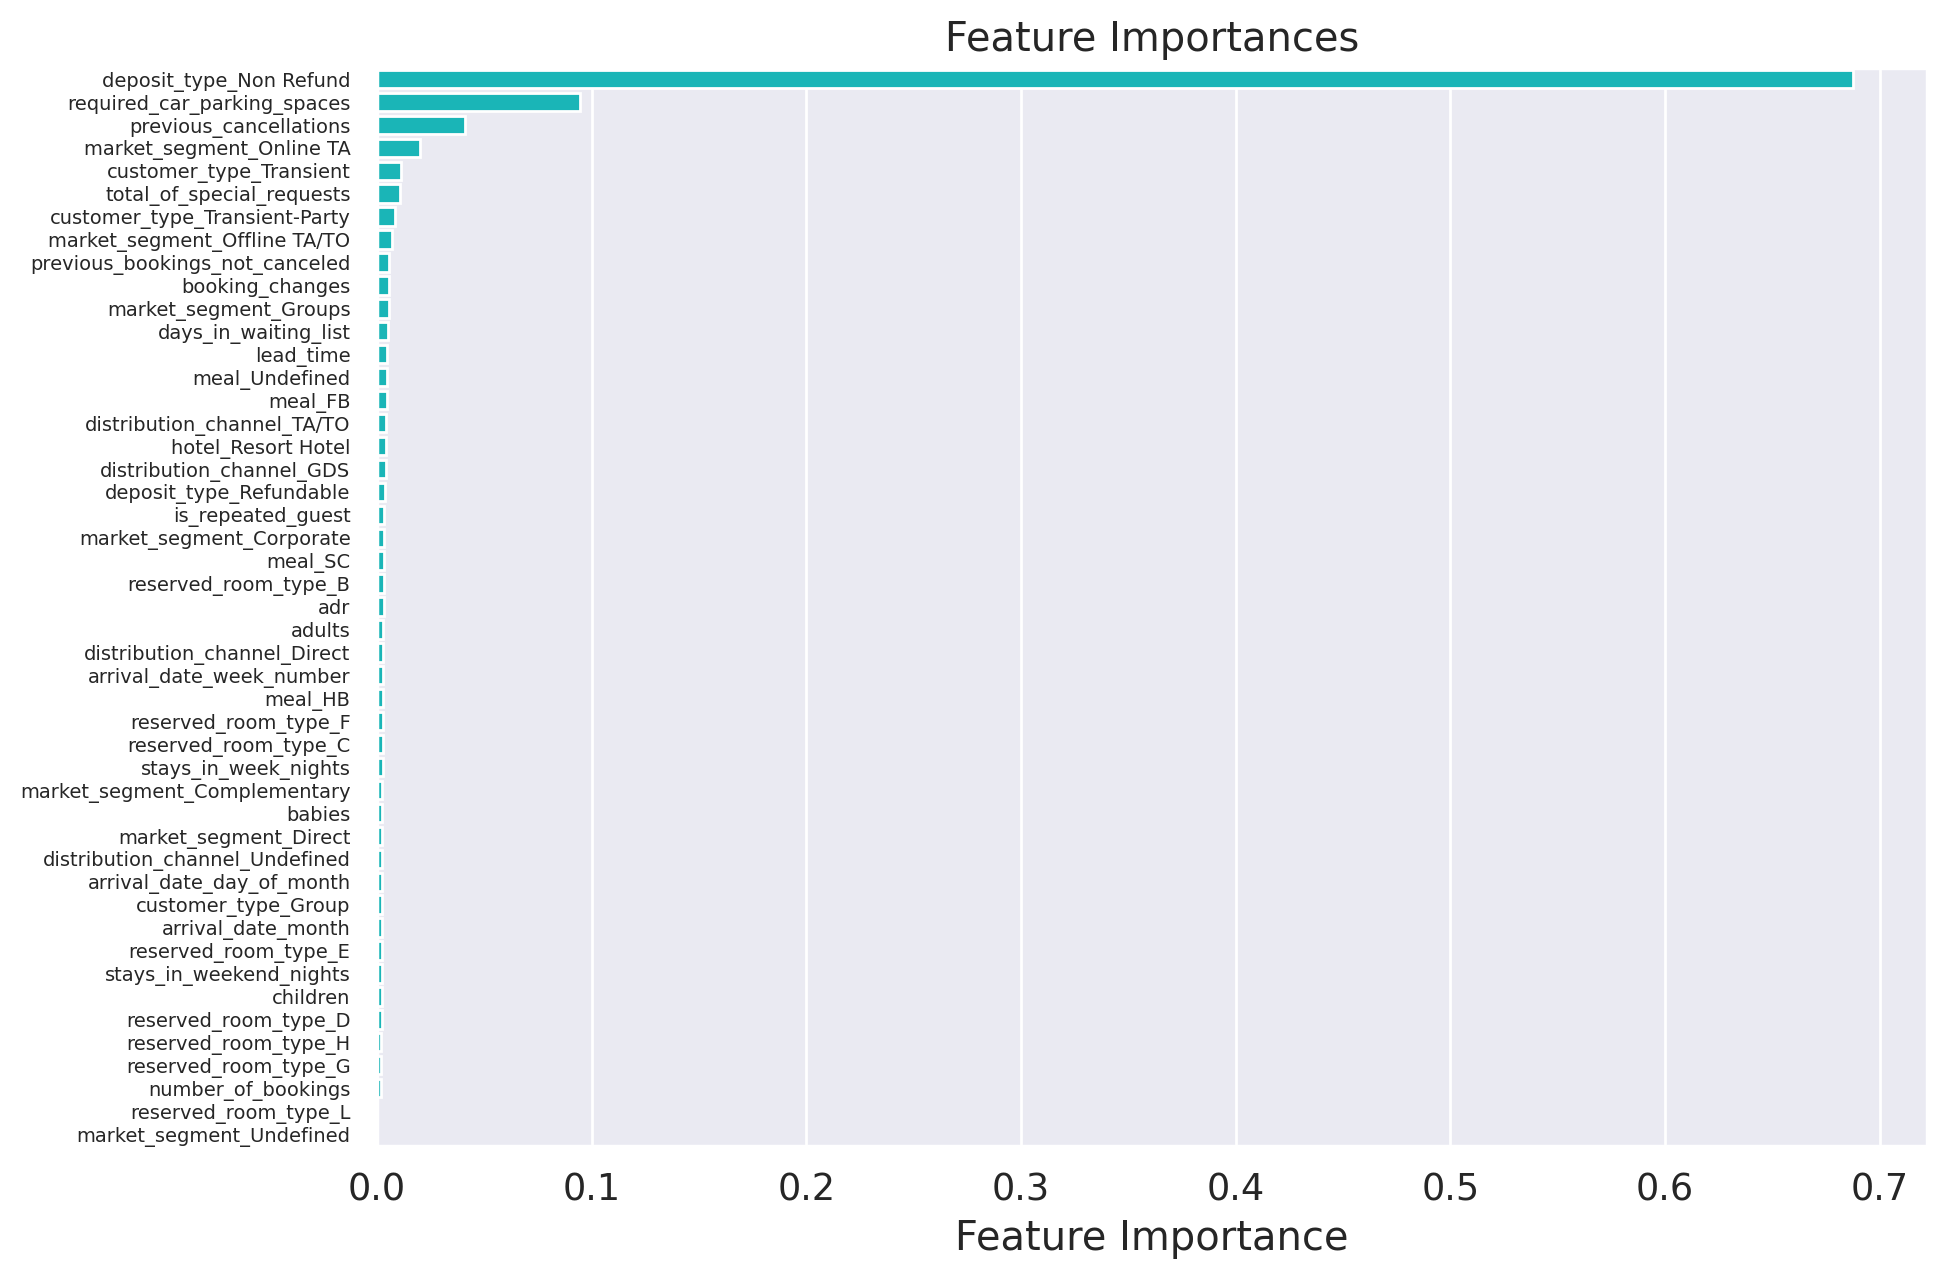

In [53]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

<h3 align="left"><font color=royalblue>Inference:</font></h3>

The __XGBoost__ model has found that features related to the __deposit type__, __previous cancellations__, __car parking requirements__, __market segment__, and __customer type__ are the __most important features__ for predicting cancellations. This suggests that the financial and logistical aspects, as well as the booking channel and customer category, are particularly important in determining whether a booking will be canceled.

<a id="conclusion"></a>
# <p style="background-color:royalblue; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 8 | Conclusion</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

As we explained earlier, the most important metric for this project is the F1-score for class '1' (canceled). A high F1-score indicates a balance between minimizing the cost associated with false negatives (overbooking rooms expecting cancellations that do not happen) and false positives (predicting cancellations when the guest actually arrives), which is crucial for the hotel to optimize room availability while minimizing overbooking and unsatisfied customers.

Next, we can check the performance of all previous classifiers based on metrics:

In [54]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
XGBoost,84.86%,79.42%,79.85%,79.63%,92.11%
Random Forest,83.78%,77.41%,79.43%,78.41%,91.38%
Decision Tree,80.3%,70.5%,80.61%,75.22%,88.63%


<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:115%; text-align:left">

Below, the F1-score for class '1' (canceled) of all previously evaluated classifiers is illustrated in a bar chart:

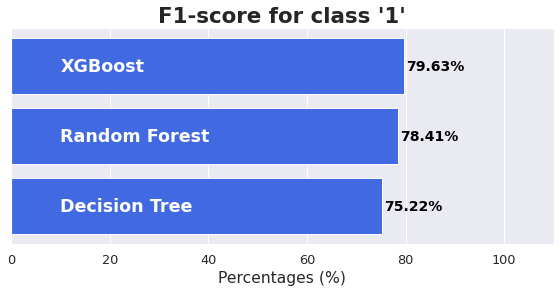

In [55]:
# Prepare values
results.sort_values(by='F1-score (Class 1)', ascending=True, inplace=True)
f1_scores = results['F1-score (Class 1)'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='black')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #d1d1ed; font-size:120%; text-align:left">

Among all the tested classifiers, __XGBoost__ had the best performance in predicting hotel booking cancellations:

🏆 __Accuracy = 85.04%__
    
🏆 __F1-score (Class 1) = 79.85%__
    
🏆 __Precision (Class 1) = 79.76%__
    
🏆 __Recall (Class 1) = 79.94%__
    
🏆 __AUC (Class 1) = 92.17%__

<div style="display: flex; align-items: center; justify-content: center; border-radius: 10px; padding: 20px; background-color: #d1d1ed; font-size: 120%; text-align: center;">

<strong>🎯 If you need more information or want to explore the code, feel free to visit the project repository on <a href="https://github.com/FarzadNekouee/Hotel_Booking_Cancellation_Prediction">GitHub</a> 🎯</strong>
</div>


<h2 align="left"><font color='royalblue'>Best Regards!</font></h2>